# Predicting Customer Churn using Bank Customers

## 1. Abstract ( working on it)


The goal of this notebook is to implement and understand the interpretation done by SHapley Additive exPlanations for a binary classification example - Customer Churn using Bank Customers.

In this notebook, I am implementing Random Forest model to predict the customer churn which has accuracy of 86% and understand how each feature has impact in the predictions using TreeExplainer.

I did feature selection using sk-learn's SelectKBest method but the outcome of feature selection did not justify the EDA results.

From the above summary plot, it can be inferred that age,gender_male, IsActiveMember, geography_france, and number of prodcuts are most important features and this is conformed by EDA plot.

From the above summary plot usingSHAP, it can be inferred that gender_male, age, geography_france, IsActiveMember and number of prodcuts are most important features and this is confirmed by EDA plot.

The feature age in the SHAP summary plot has highest importance which is verified by the EDA graphs


## 2. Import libraries

Importing libraries:

Pandas for handling and analysing data,
Seaborn and Matplotlib for data visualization, and
Scikit-learn for building Machine Learning models.

In [106]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import scikitplot as skplt

label_size = 17

plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 2
plt.rcParams['ytick.labelsize'] = label_size - 2
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['legend.fontsize'] = label_size - 2

random_state = 42
scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

In [170]:
df = pd.read_csv('Churn_Modelling.csv')

print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 10000 rows and 14 columns.


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

##### Details about the dataset:

It consists of 10000 observations and 12 variables. Independent variables contain information about customers. Dependent variable refers to customer abandonment status.

Variables:

RowNumber — corresponds to the record (row) number and has no effect on the output. This column will be removed.

CustomerId — contains random values and has no effect on customer leaving the bank. This column will be removed.

Surname — the surname of a customer has no impact on their decision to leave the bank. This column will be removed.

CreditScore — can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

Geography — a customer’s location can affect their decision to leave the bank. 

Gender — it’s interesting to explore whether gender plays a role in a customer leaving the bank. 

Age — this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

Tenure — refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

Balance — also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

NumOfProducts — refers to the number of products that a customer has purchased through the bank.

HasCrCard — denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank. (0=No,1=Yes)

IsActiveMember — active customers are less likely to leave the bank, so we’ll keep this. (0=No,1=Yes)

EstimatedSalary — as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

Exited — whether or not the customer left the bank. This is what we have to predict. (0=No,1=Yes)

The info() method can give us valuable information such as the number of non-null values and the type of each feature:

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no missing values in the dataset. 

Columns 'RowNumber', 'CustomerID' and 'Surname' are specific to each customer and can be dropped:

In [171]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1, inplace = True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

## 3. Exploratory data analysis

In [5]:
import pandas_profiling
df.profile_report()

In [110]:
df.describe().T

count        mean        std     min       25%         50%  \
CreditScore      10000.0     650.529     96.653  350.00    584.00     652.000   
Age              10000.0      38.922     10.488   18.00     32.00      37.000   
Tenure           10000.0       5.013      2.892    0.00      3.00       5.000   
Balance          10000.0   76485.889  62397.405    0.00      0.00   97198.540   
NumOfProducts    10000.0       1.530      0.582    1.00      1.00       1.000   
HasCrCard        10000.0       0.706      0.456    0.00      0.00       1.000   
IsActiveMember   10000.0       0.515      0.500    0.00      0.00       1.000   
EstimatedSalary  10000.0  100090.240  57510.493   11.58  51002.11  100193.915   
Exited           10000.0       0.204      0.403    0.00      0.00       0.000   

                        75%        max  
CreditScore         718.000     850.00  
Age                  44.000      92.00  
Tenure                7.000      10.00  
Balance          127644.240  250898.09  
NumOfProducts         2.000       4.00  
HasCrCard             1.000       1.00  
IsActiveMember        1.000       1.00  
EstimatedSalary  149388.247  199992.48  
Exited                0.000       1.00

The most important things to note are:

    1. The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,
    2. The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3), and
    3. Approximately 50% of customers are active.
    
entropy of column

Text(0, 0.5, 'Count')

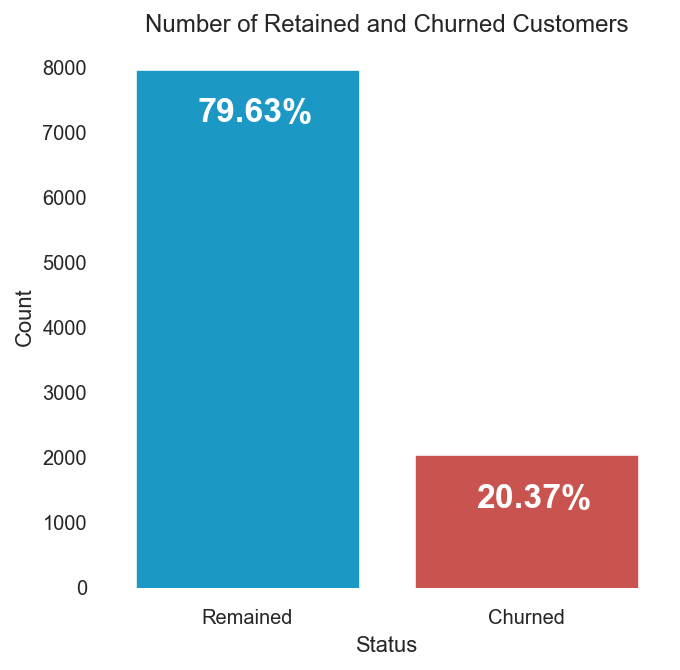

In [7]:
colors = ['#00A5E0', '#DD403A']

fig = plt.figure(figsize = (5, 5))

# plot the graph
sns.countplot(x = 'Exited', data = df, palette = colors)

for index, value in enumerate(df['Exited'].value_counts()):
    label =  '{}%'.format(round( (value/df['Exited'].shape[0])*100, 2)) 
    plt.annotate(label, xy = (index - 0.18, value - 800), color = 'w', fontweight = 'bold', size = label_size)

plt.title('Number of Retained and Churned Customers')
plt.xticks([0, 1], ['Remained', 'Churned'])
plt.xlabel('Status')
plt.ylabel('Count')

The bank kept 80% of its clientele.

The dataset is skewed/imbalanced since the number of instances in the 'Remained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.


Different visualisation techniques apply to different types of variables, so it's useful to differentiate between continuous and categorical variables and look at them separately.



### Continuous Variables

By calling the hist() method we can plot a histogram for each of the four continuous numeric features:

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'CreditScore'}>],
       [<AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>]], dtype=object)

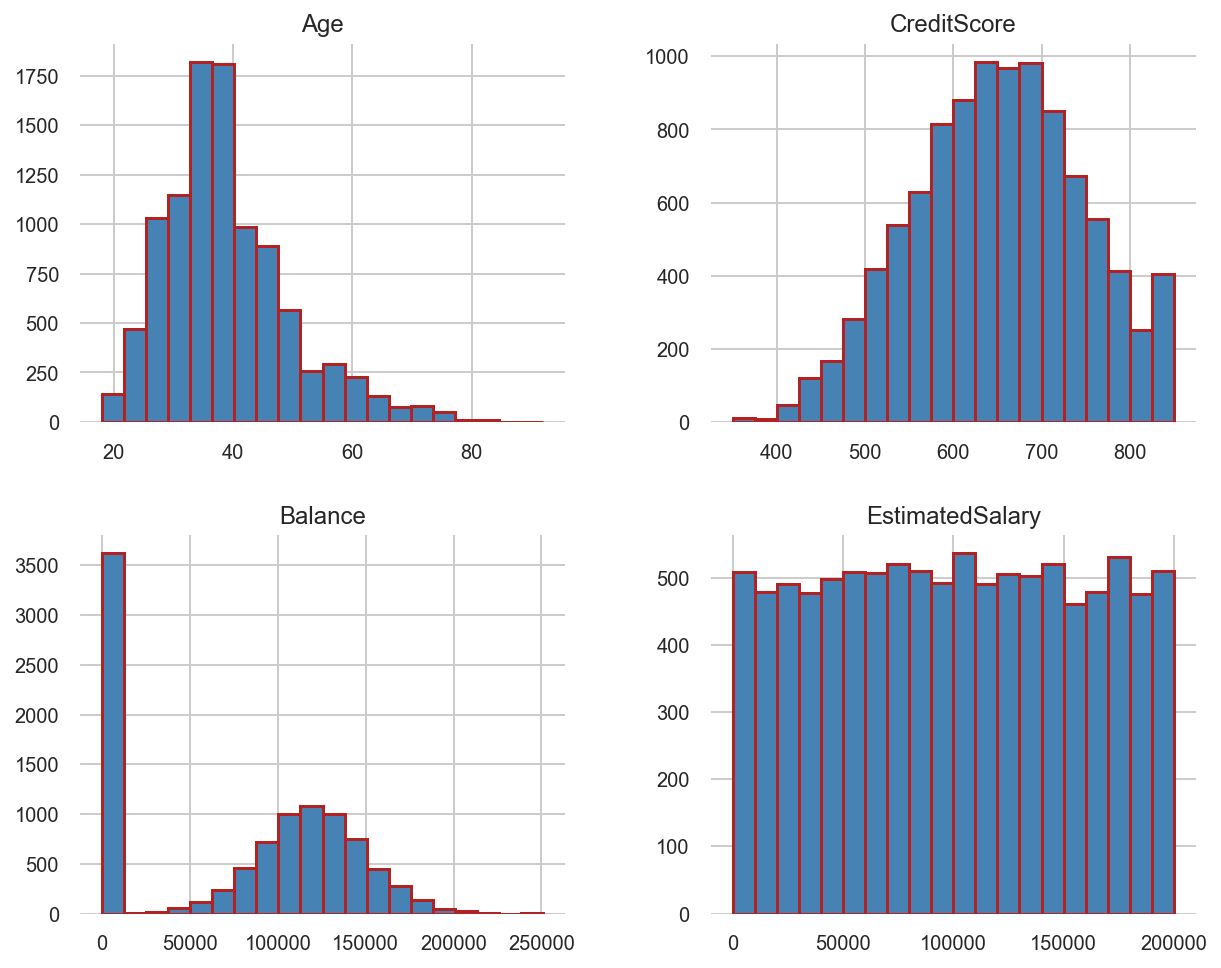

In [8]:
continuous = ['Age','CreditScore','Balance','EstimatedSalary']
df[continuous].hist(figsize =(10,8), bins = 20, layout=(2,2), color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5)

### Observations:

1. 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left
 
 automated test for normaility


2. Most values for 'CreditScore' are above 600
3. If we ignore the fist bin, 'Balance' follows a fairly normal distribution
4. The distribution of 'EstimatedSalary' is more or less uniform and provides little information.



## Categorical Variables
Let's plot a countplot for each categorical feature:

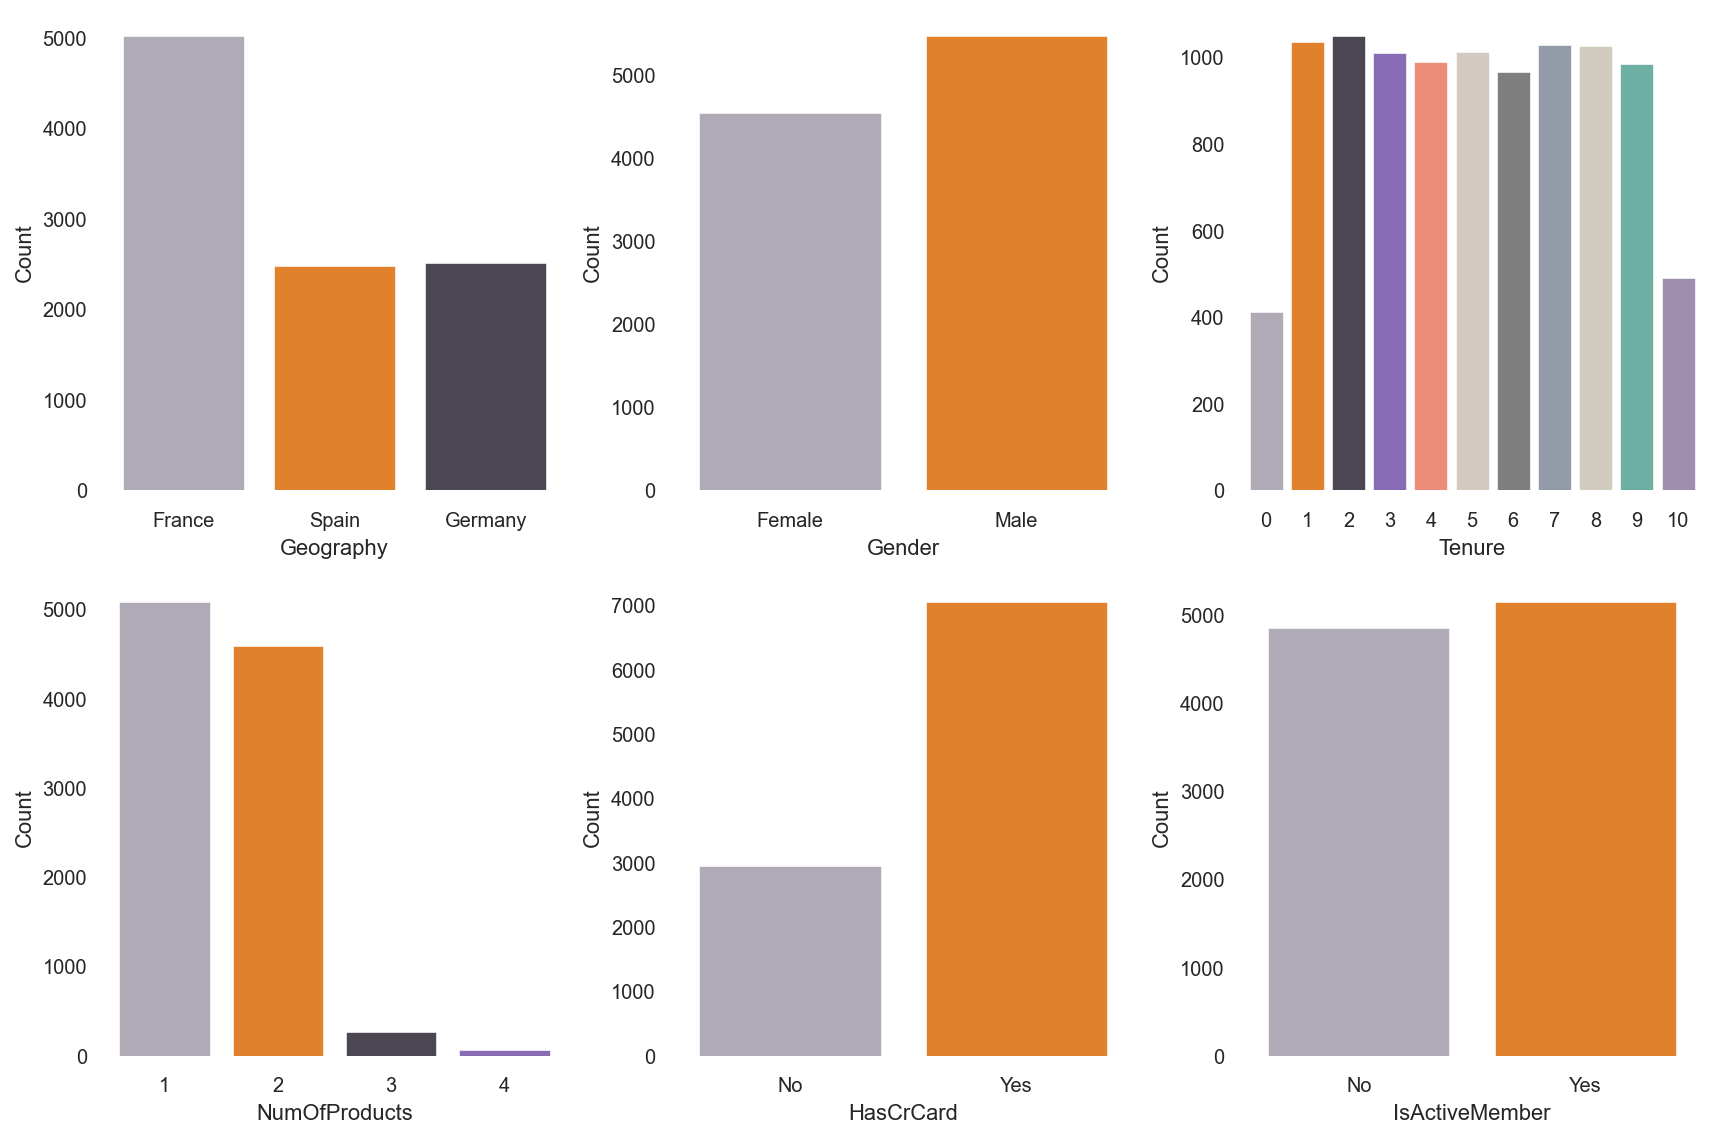

In [9]:
colors2 = ['#B0A8B9', '#ff7f0e', '#4B4453', '#845EC2', '#FF8066', '#D5CABD', 
           '#7f7f7f', '#8f9aaa', '#d4cebb',  '#63BAAA', '#9D88B3']

cat_vars = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_cat = df[cat_vars]

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x = column, data = df, palette = colors2)
    
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'): 
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

### Observations:

1. The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
2. There are more male customers than females
3. Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
4. Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
5. A significant majority of customers has a credit card, and
6. Almost 50% of customers are not active.

In [10]:
def plot_continuous(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    
    sns.distplot(df_remained[feature], bins = 15, color = colors[0], label = 'Remained', 
                 hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    sns.distplot(df_churned[feature], bins = 15, color = colors[1], label = 'Churned', 
                 hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    ax1.set_title('{} distribution - Histogram'.format(feature))
    ax1.set_ylabel('Counts')
    ax1.legend()

    sns.boxplot(x = 'Exited', y = feature, data = df, palette = colors, ax = ax2)
    ax2.set_title('{} distribution - Box plot'.format(feature))
    ax2.set_xlabel('Status')
    ax2.set_xticklabels(['Remained', 'Churned'])

    plt.tight_layout();

In [11]:
def plot_categorical(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    sns.countplot(x = feature, hue = 'Exited', data = df, palette = colors, ax = ax1)
    ax1.set_ylabel('Counts')
    ax1.legend(labels = ['Retained', 'Churned'])
    
    sns.barplot(x = feature, y = 'Exited', data = df, palette = colors2 , ci = None, ax = ax2)
    ax2.set_ylabel('Churn rate')
    
    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])
    
    plt.tight_layout();

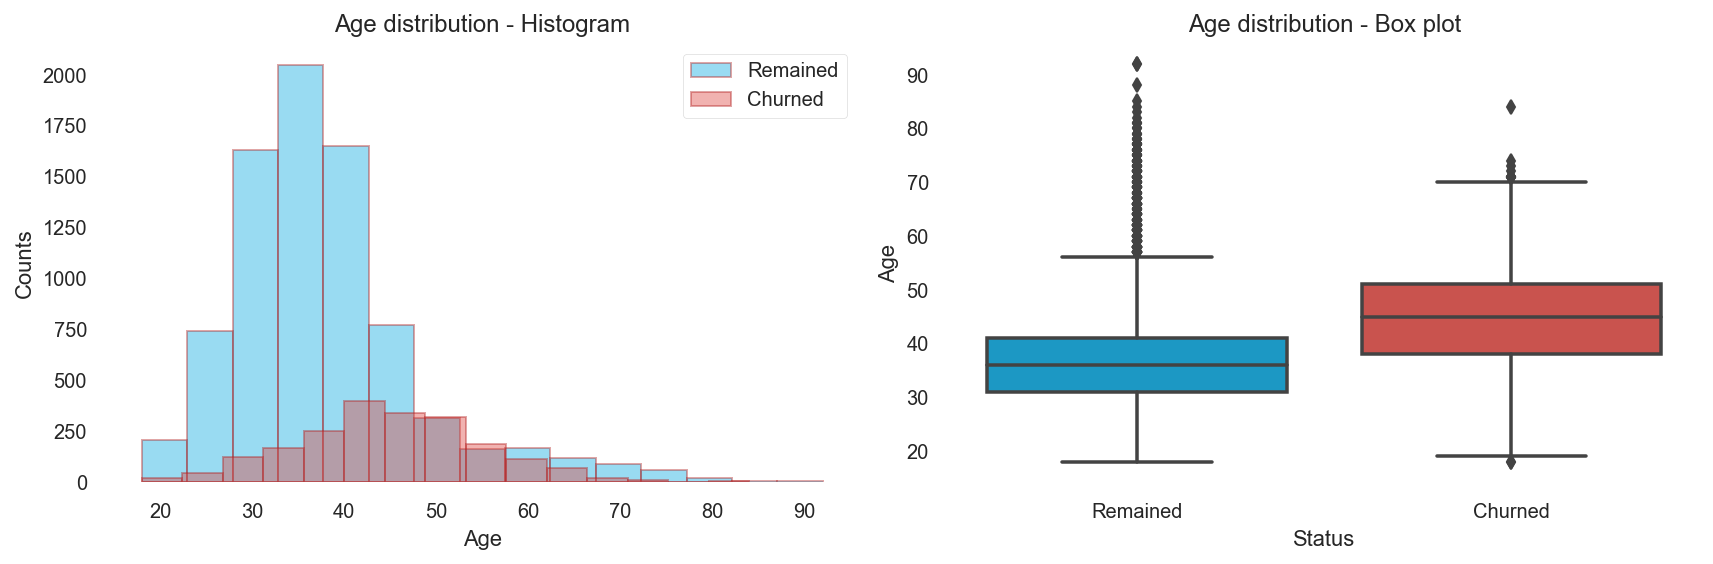

In [12]:
df_churned = df[df['Exited'] == 1]
df_remained = df[df['Exited'] == 0]

plot_continuous('Age')

There is a clear difference between age groups since older customers are more likely to churn. This could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

It clear that 50% likely to leave if 50.. 

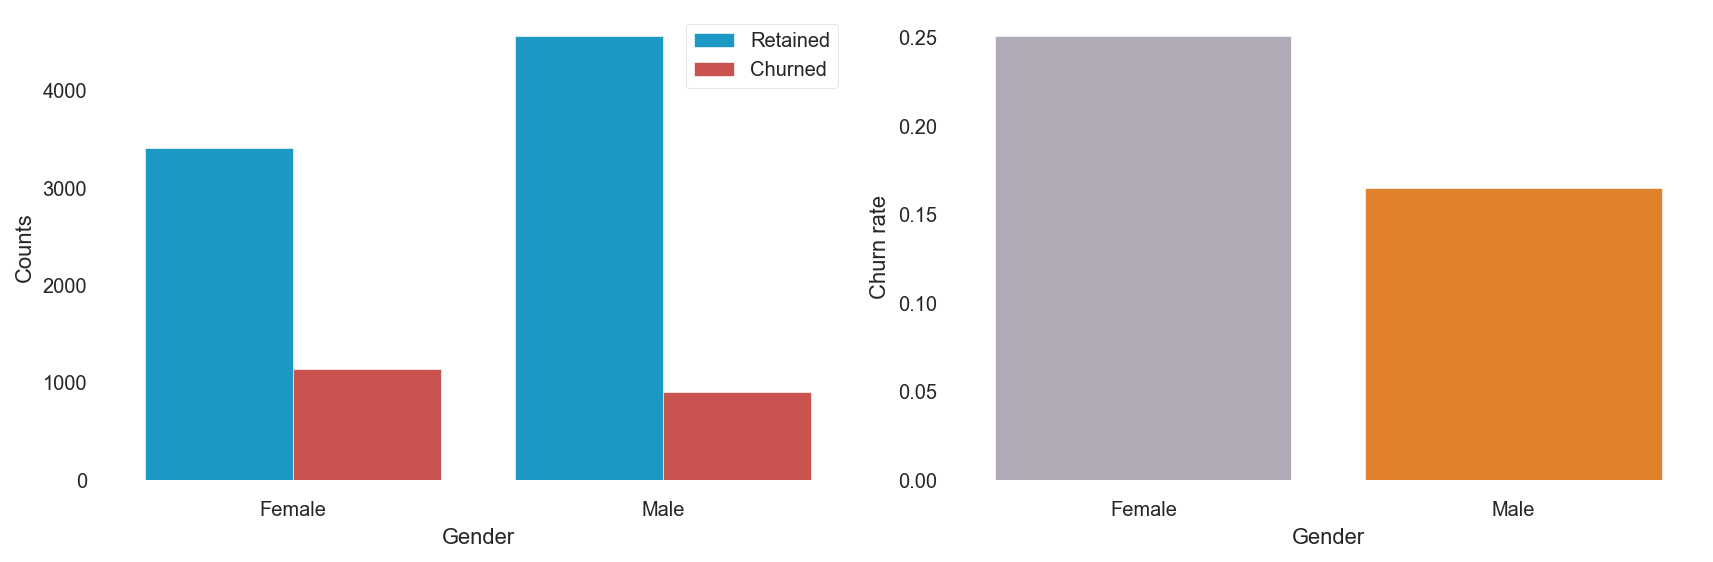

In [13]:
plot_categorical('Gender')

Female customers are more likely to churn.   ( which is more imp age or gender) 

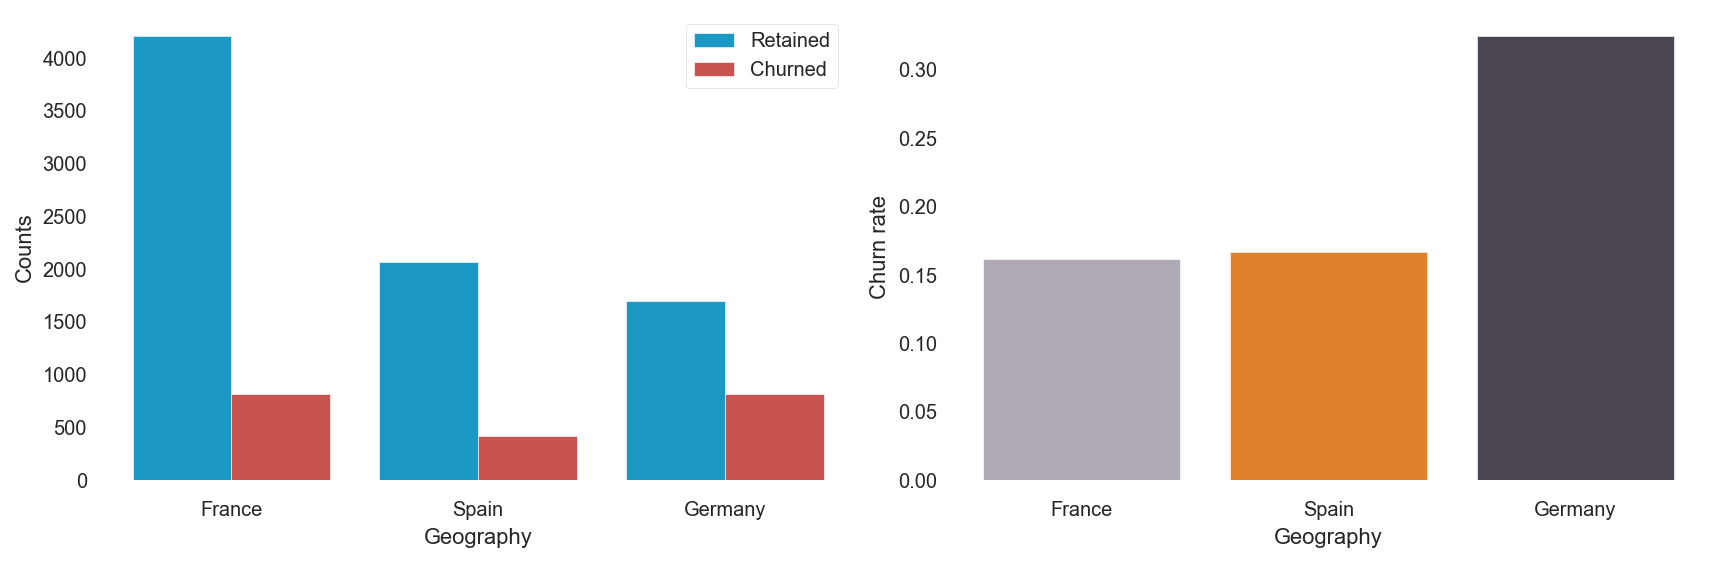

In [14]:
plot_categorical('Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding such as higher competition or different preferences for German customers.

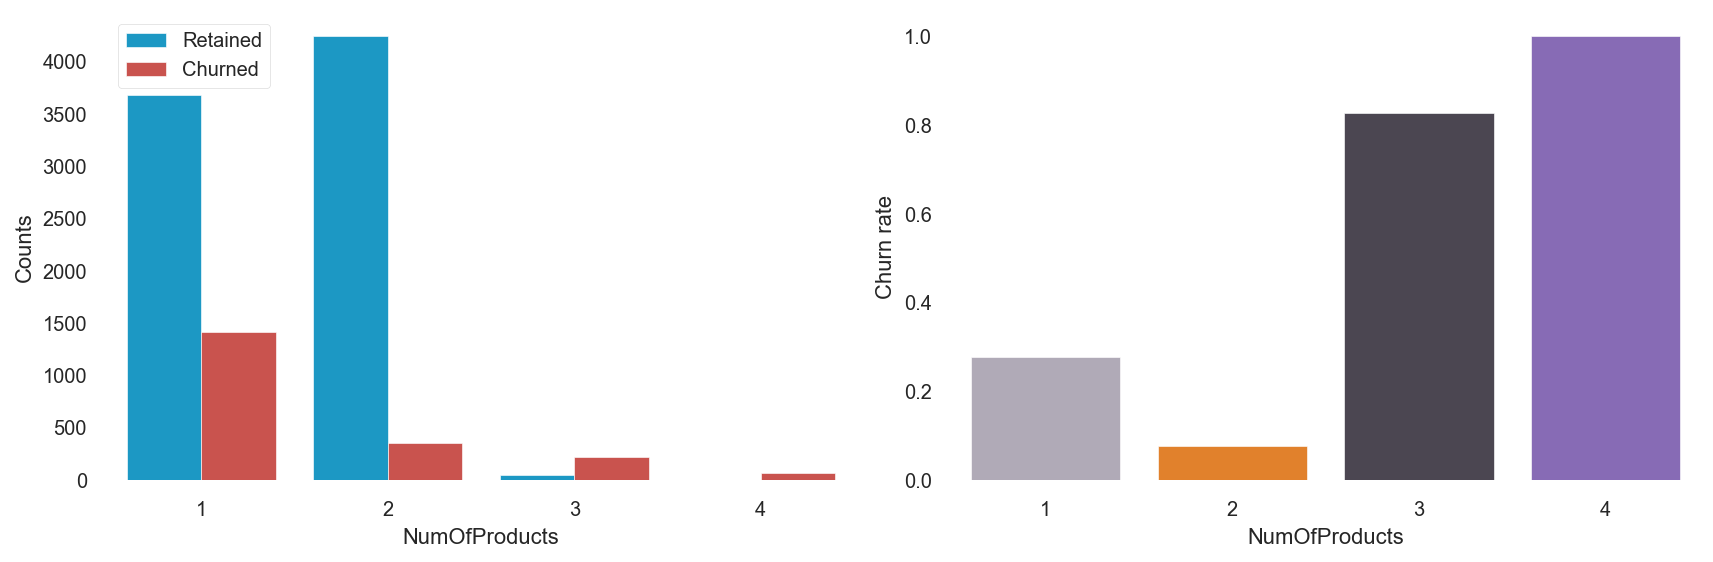

In [15]:
plot_categorical('NumOfProducts')

having 3 or 4 products significantly increases the likelihood of churn.

I am not sure how to interpret this result. It could potentially mean that the bank is unable to properly support customers with more products which in turn increases customer dissatisfaction.

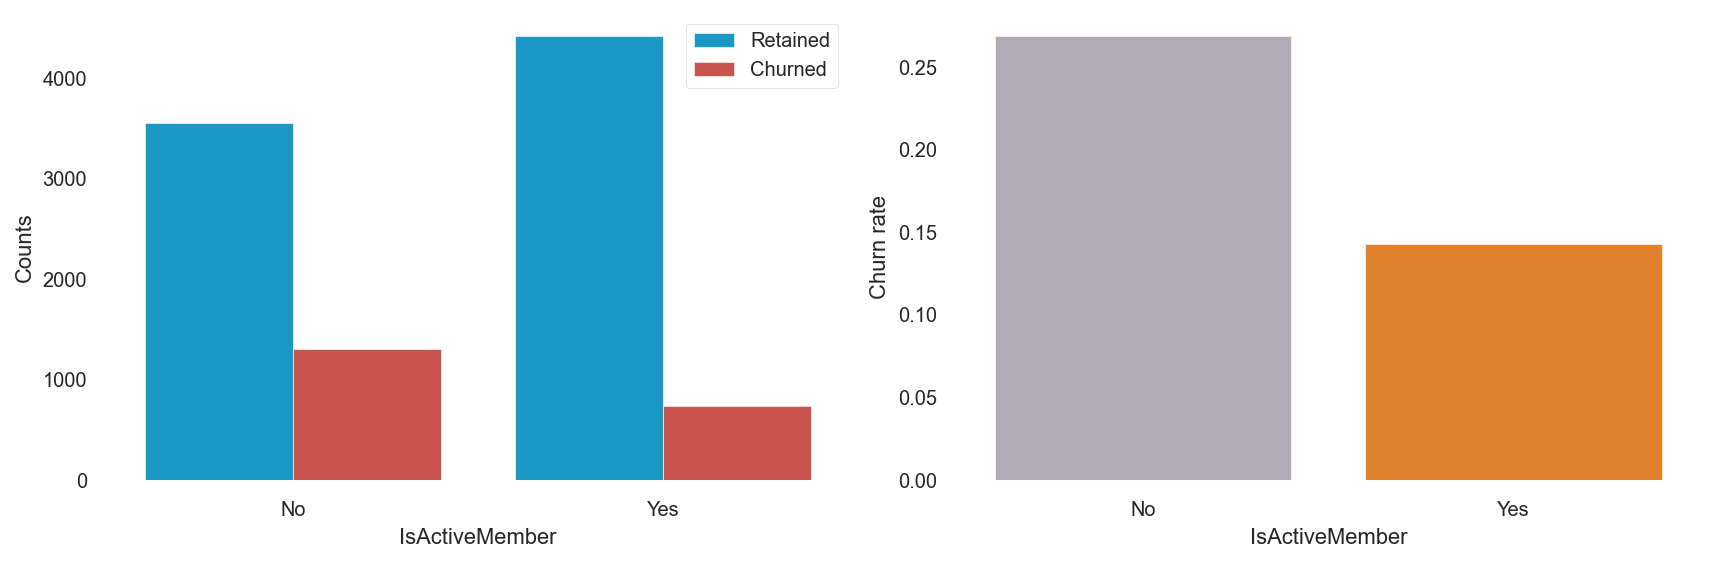

In [16]:
plot_categorical('IsActiveMember')

It's not a surprise that inactive customers are more likely to churn. A big portion of the clientele is inactive; therefore, the bank will definitely benefit from changing its policy so that more customers become active.

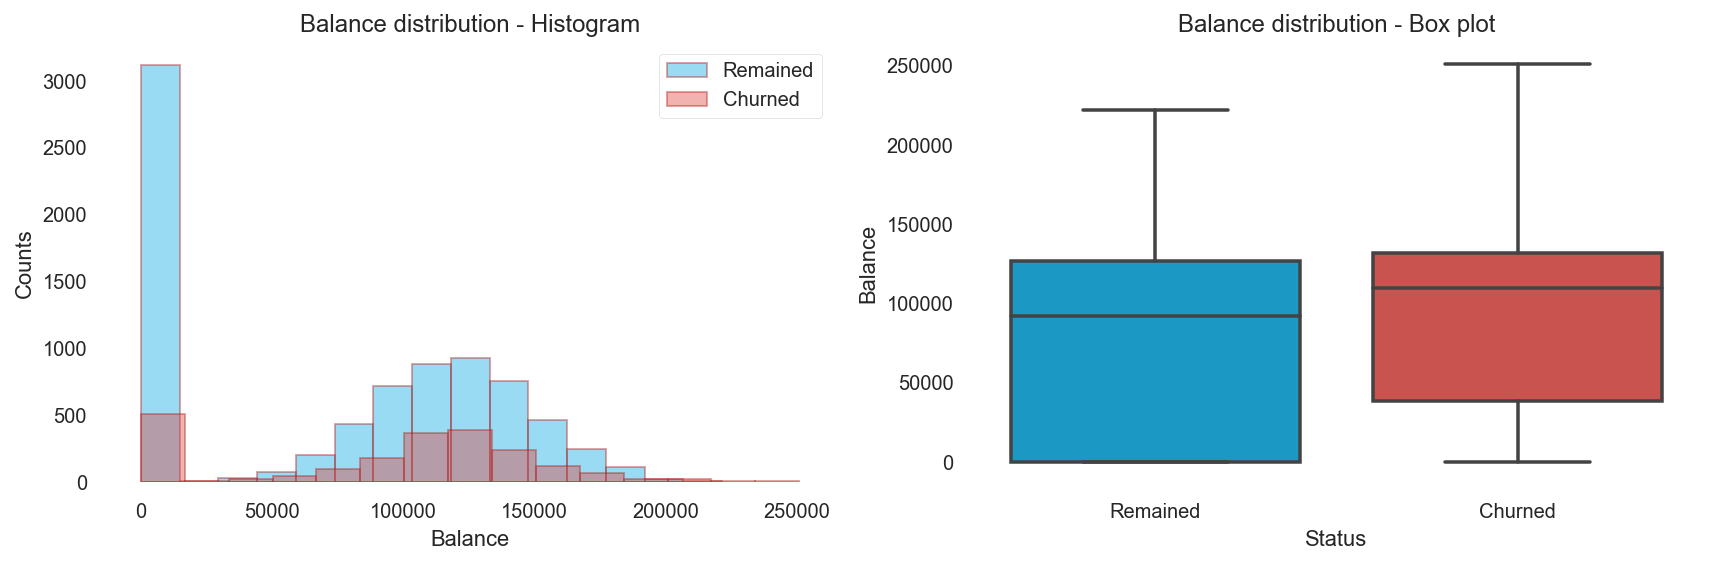

In [17]:
plot_continuous('Balance')

The two distributions are quite similar. There is a big percentage of non-churned customers with a low account balance.

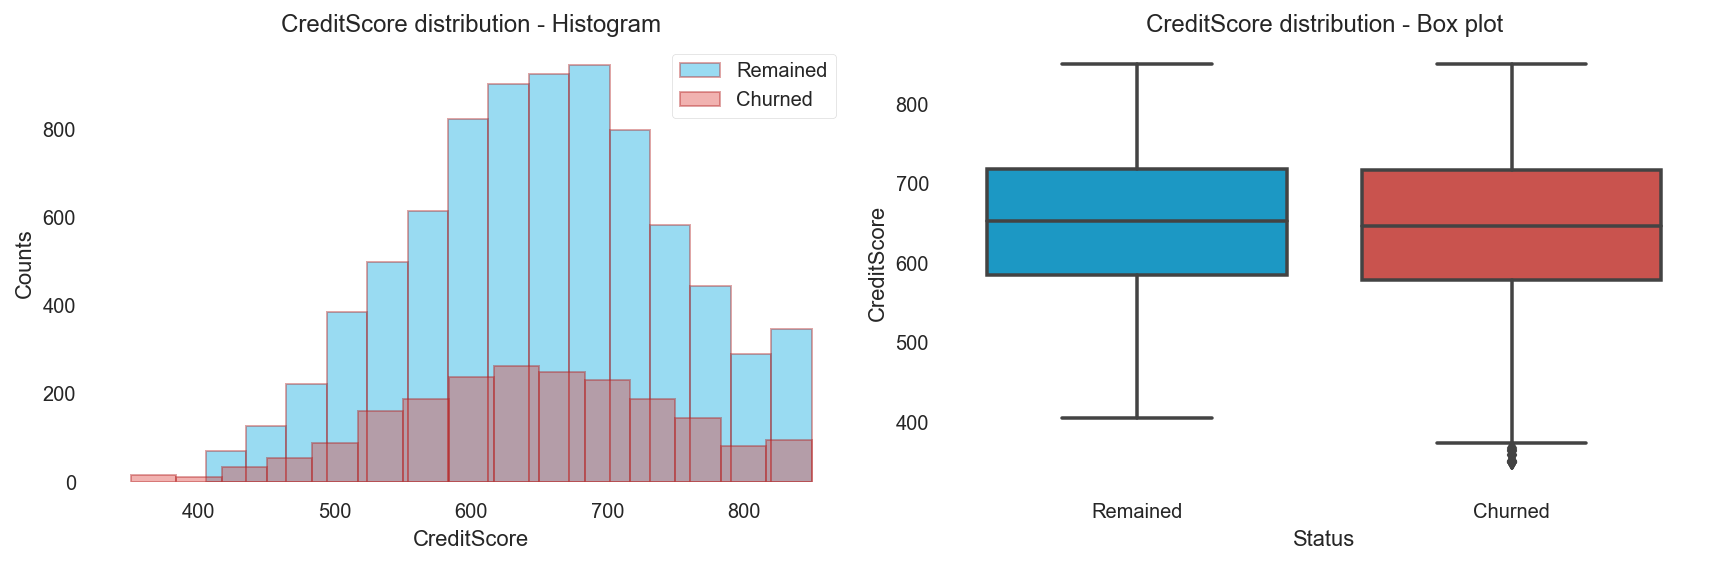

In [18]:
plot_continuous('CreditScore')

There is no significant difference between retained and churned customers in terms of their credit score.

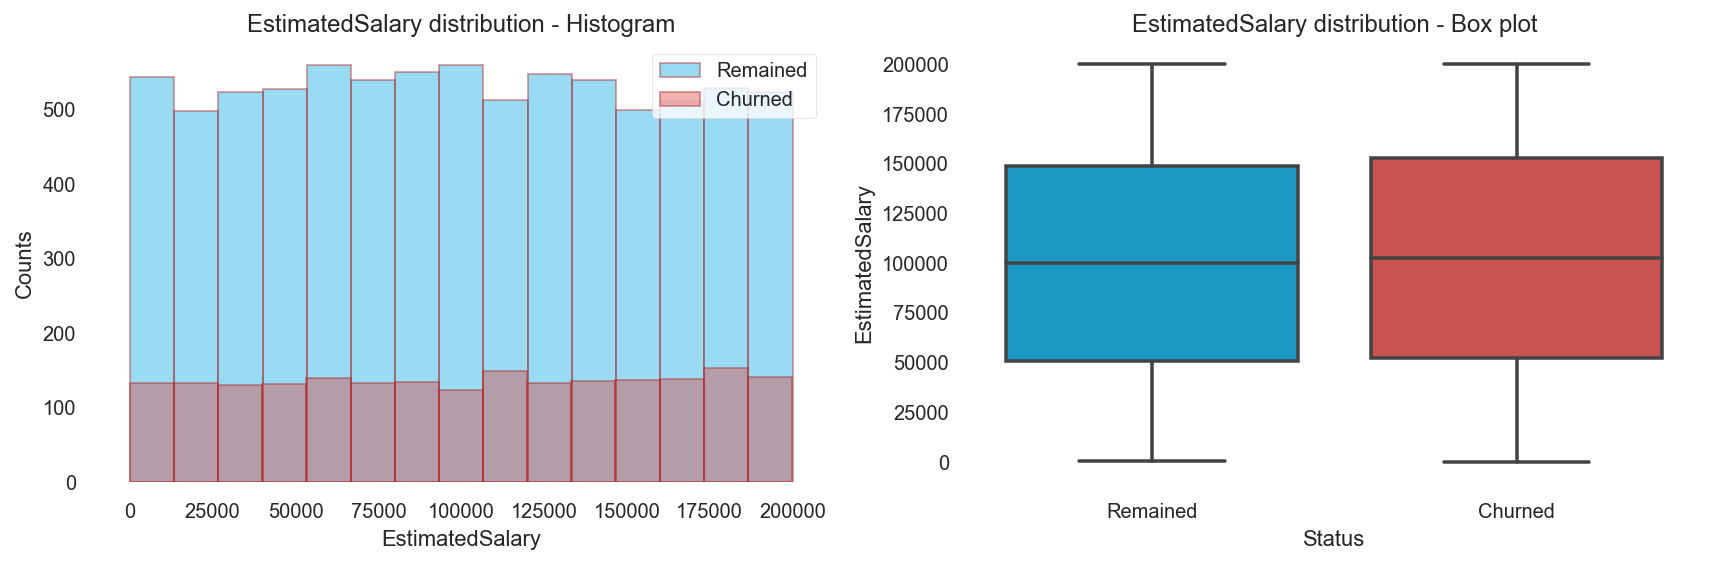

In [19]:
plot_continuous('EstimatedSalary')

Both churned and retained customers display a similar uniform distribution for their salary. Consequently, we can conclude that salary doesn't have a significant effect on the likelihood to churn.

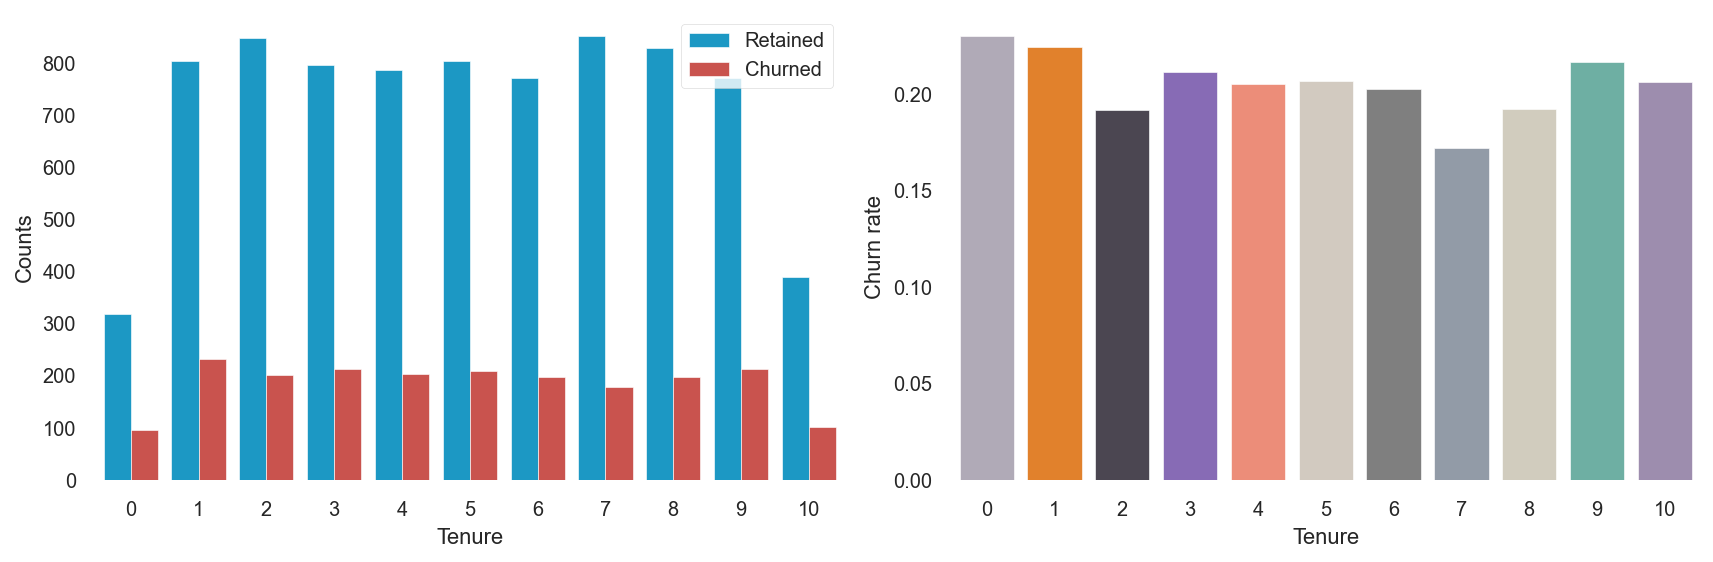

In [20]:
plot_categorical('Tenure')

Tenure does not seem to affect the customer churn. It is most likely for customers to churn either at the start or end of the tenure

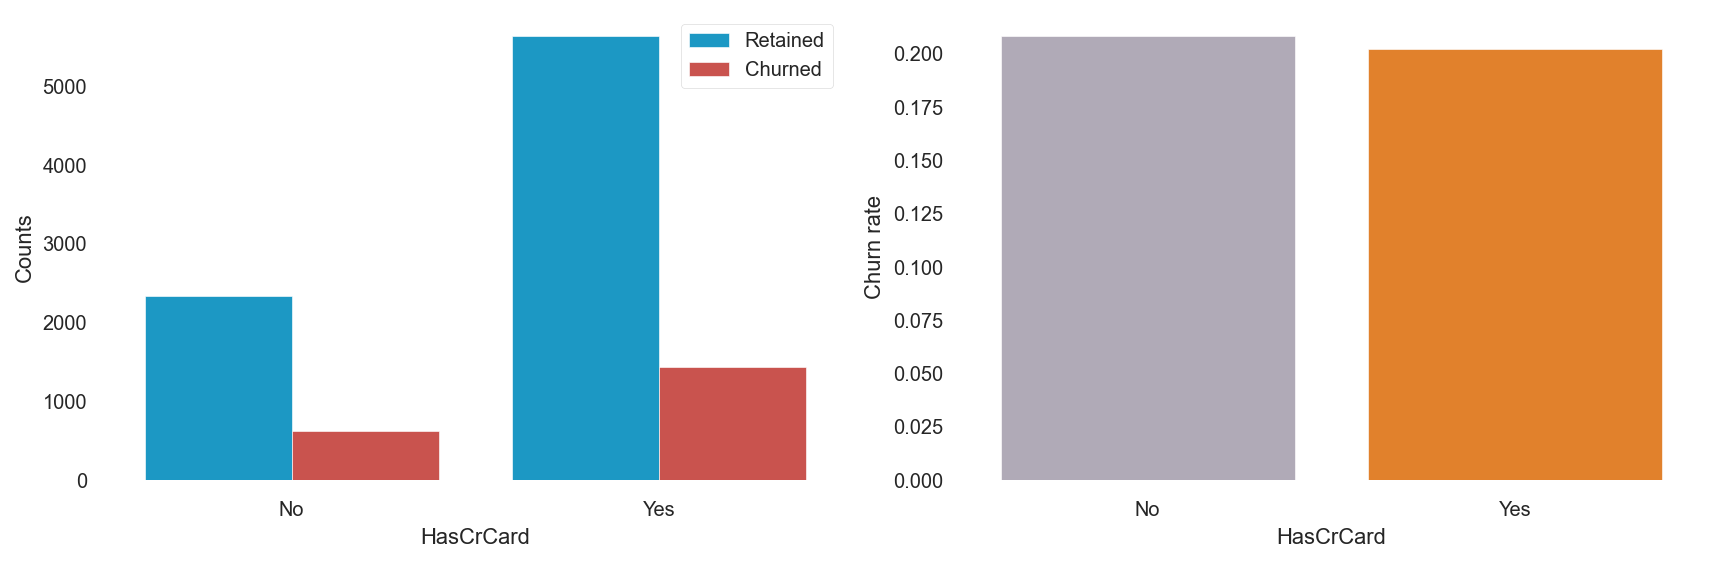

In [21]:
plot_categorical('HasCrCard')

Having a credit card doesn't seem to affect the churn rate.

## 4. Data Preprocessing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

Encoding Categorical Features:

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before using them for building models.

In this dataset, geography and gender was encoded.

In [172]:
# One-Hot encoding the categorical attributes
list_cat = ['Geography', 'Gender']
df = pd.get_dummies(df, columns = list_cat, prefix = list_cat)
#df.head()

In [173]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography_France',
            'Geography_Germany','Geography_Spain','Gender_Female','Gender_Male']
df = df[continuous_vars + cat_vars + ['Exited']]
df.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  EstimatedSalary  \
0          619   42       2       0.00              1        101348.88   
1          608   41       1   83807.86              1        112542.58   
2          502   42       8  159660.80              3        113931.57   
3          699   39       1       0.00              2         93826.63   
4          850   43       2  125510.82              1         79084.10   

   HasCrCard  IsActiveMember  Geography_France  Geography_Germany  \
0          1               1                 1                  0   
1          0               1                 0                  0   
2          1               0                 1                  0   
3          0               0                 1                  0   
4          1               1                 0                  0   

   Geography_Spain  Gender_Female  Gender_Male  Exited  
0                0              1            0       1  
1                1              1            0       0  
2                0              1            0       1  
3                0              1            0       0  
4                1              1            0       0

## 6. Feature Selection:

Already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning of the notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:

In [113]:
# Identify the features with the most importance for the outcome variable exited

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df.drop('Exited', axis=1)  
y = df.Exited  

#Using 'SelectKBest method to identify most important features
bestfeatures = SelectKBest(score_func=chi2)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']   

#SOrting features by 'scores'
featureScores = featureScores.sort_values(by='Score', ascending=False)
featureScores

Specs      Score
3             Balance  7.151e+06
5     EstimatedSalary  4.835e+04
1                 Age  2.300e+03
9   Geography_Germany  2.255e+02
7      IsActiveMember  1.182e+02
0         CreditScore  1.054e+02
11      Gender_Female  6.191e+01
8    Geography_France  5.492e+01
12        Gender_Male  5.154e+01
10    Geography_Spain  2.087e+01
4       NumOfProducts  5.055e+00
2              Tenure  3.271e+00
6           HasCrCard  1.500e-01

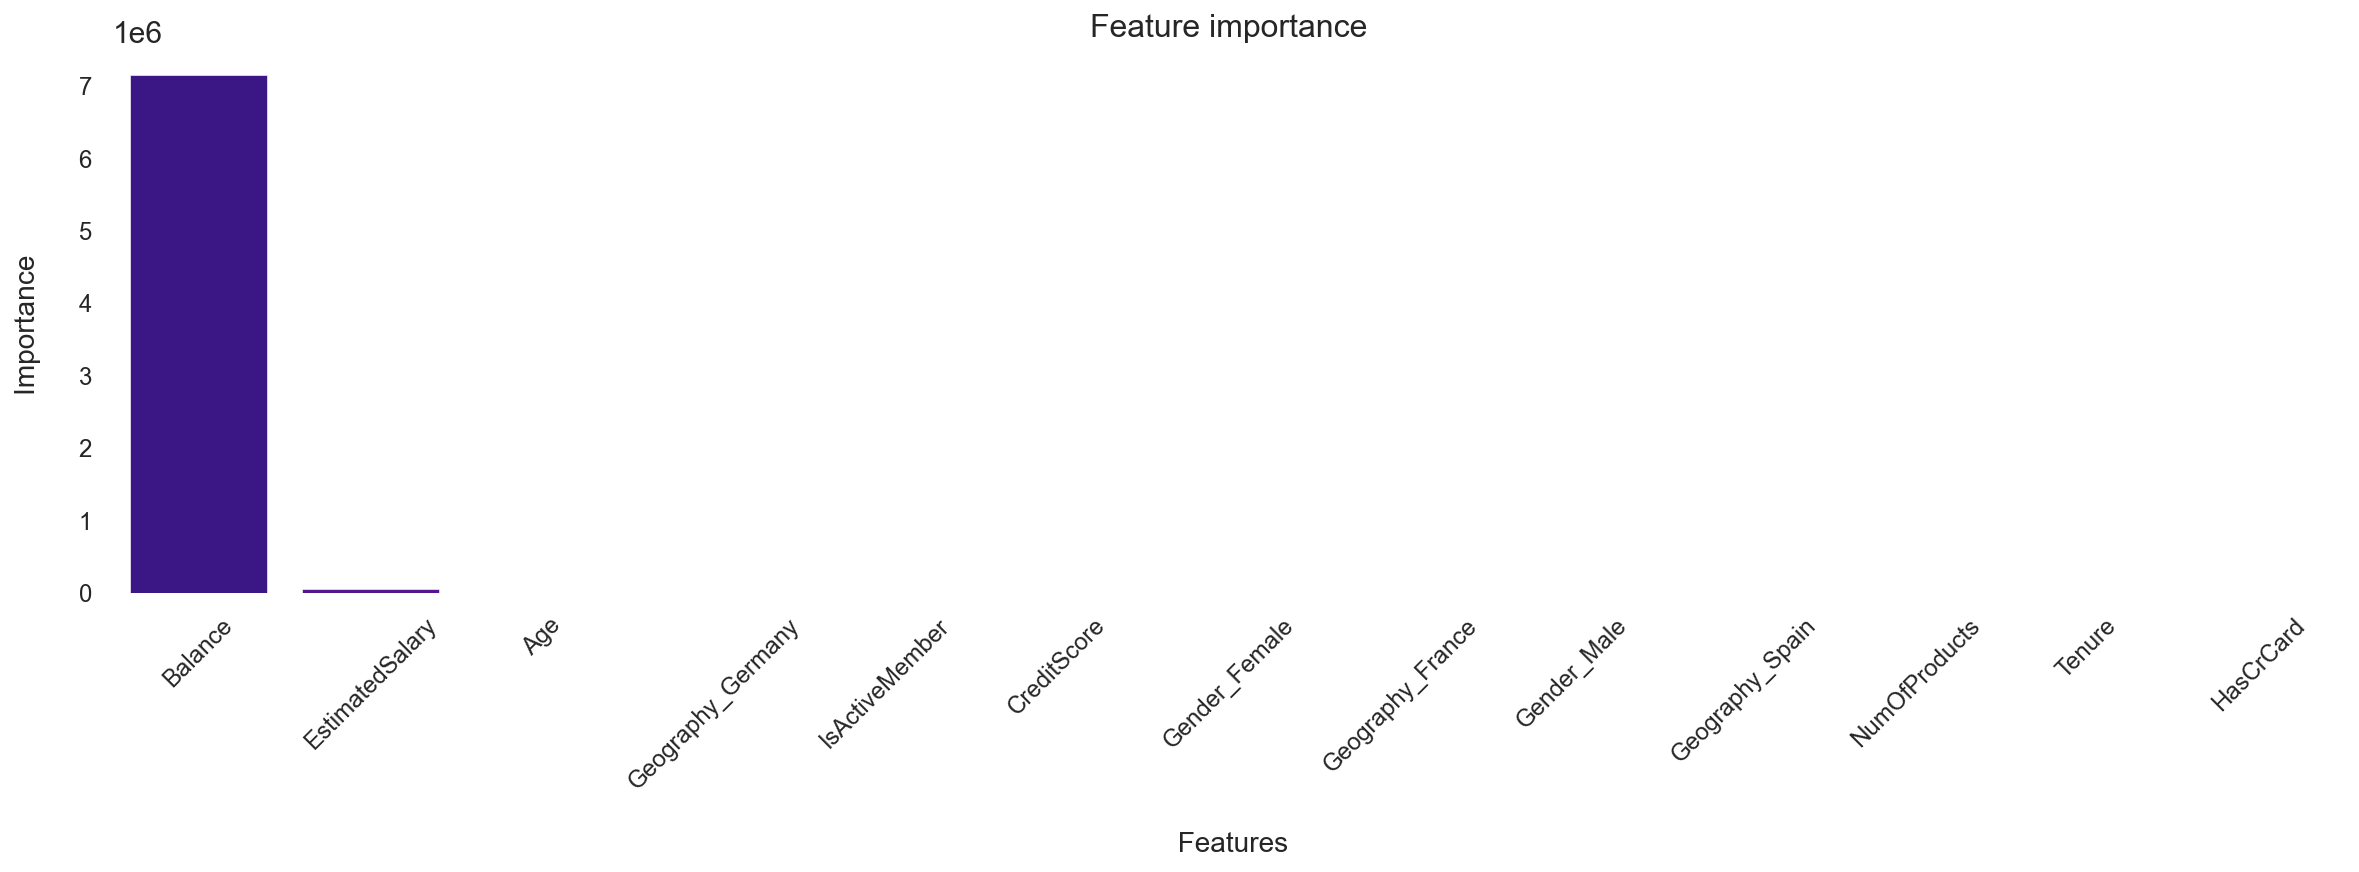

In [114]:
#Plot for visualization of feature importance

plt.figure(figsize=(20,5))
sns.barplot(x='Specs', y='Score', data=featureScores, palette = "plasma")
plt.box(False)

plt.title('Feature importance', fontsize=16)
plt.xlabel('\n Features', fontsize=14)
plt.ylabel('Importance \n', fontsize=14)
plt.xticks(fontsize=12, rotation = 45)
plt.yticks(fontsize=12)

plt.show()

#### Observations:

From the above graph it can be concluded that only balance has a high impact on customer churn prediction which is not true and is not support by the EDA. 

In [174]:
# New dataframe with important features
df_bank = df[['Geography_Germany','IsActiveMember', 'Gender_Female', 'Age', 'Geography_France',
              'Gender_Male', 'Balance','Geography_Spain','NumOfProducts','CreditScore','Tenure',
              'EstimatedSalary','HasCrCard','Exited']]

## 7. Train test split

The code below splits the training data. Using 75%  of the training data for actual training purposes, and once training is completed, using the remaining  25%  of the training data to check the training accuracy of the trained model.

In [175]:
x = df_bank.drop('Exited', axis=1)  
y = df_bank.Exited  

# Splitting the dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)


In [176]:
# Because it's an unstable data set,increase the number of samples.
# References: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html
from imblearn.combine import SMOTETomek

smk = SMOTETomek()
# Oversample training  data
X_train, y_train = smk.fit_sample(X_train, y_train)

# Oversample validation data
X_test, y_test = smk.fit_sample(X_test, y_test)



In [177]:
# Import the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Initialization of the Random Forest model
model = RandomForestClassifier(n_estimators=10, criterion='gini')
# Fitting the model with training data 
model.fit(X_train, y_train)

model_pred = model.predict(X_test)

In [178]:
acc = accuracy_score(y_test, model_pred)
print(f"The accuracy score for RFC is: {round(acc,3)*100}%")

The accuracy score for RFC is: 85.1%


The accuracy score using all the features for Random forest classfication is 85.1%

Considering age as the only feature to predict the customer churn. This is done to check wheather age is important than gender_male.

In [147]:
x_balance = df_bank[['Age']]
y_balance = df_bank.Exited

# Splitting the dataset in training and test set
x_train, x_test, y_train, y_test = train_test_split(x_balance, y_balance, test_size = 0.25)


In [148]:
# Import the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Initialization of the Random Forest model
model = RandomForestClassifier(n_estimators=10, criterion='gini')
# Fitting the model with training data 
model.fit(x_train, y_train)

model_pred = model.predict(x_test)

In [149]:
acc = accuracy_score(y_test, model_pred)
print(f"The accuracy score for RFC is: {round(acc,3)*100}%")

The accuracy score for RFC is: 80.9%


While considering age as the only dependent feature the accuracy is 80.9%.

Considering gender_male as the only dependent feature.

In [156]:
x_gender = df_bank[['Gender_Male']]
y_gender = df_bank.Exited

# Splitting the dataset in training and test set
x_train, x_test, y_train, y_test = train_test_split(x_gender, y_gender, test_size = 0.25)

In [157]:
# Import the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Initialization of the Random Forest model
model = RandomForestClassifier(n_estimators=10, criterion='gini')
# Fitting the model with training data 
model.fit(x_train, y_train)

model_pred = model.predict(x_test)

In [158]:
acc = accuracy_score(y_test, model_pred)
print(f"The accuracy score for RFC is: {round(acc,3)*100}%")

The accuracy score for RFC is: 80.30000000000001%


While considering gender_male as the only dependent feature the accuracy is 80.3% which means age is more important feature than gender_male for churn prediction. But this is not supported by SHAP summary plot as it indicates that gender_male is more important than age

## 7. Interpretation using SHAP

TreeExplainer is a package for explaining and interpreting predictions of tree-based machine learning models. The notion of interpretability is based on how close the inclusion of a feature takes the model toward its final prediction. For this reason, the result of this approach is "feature contributions" to the predictions.

The basic idea is to decompose each prediction into feature contribution components. For a dataset with n features, each prediction on the dataset is calculated as

prediction ≈ baseline probability at tree root + contribution feature 1 + ... + contribution feature n

Feature contributions are provided at the level of observations, features, and targets.

In [191]:
#SHAP import
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test,approximate=False, check_additivity=False)

In [180]:

print(f'Shape of test dataset: {X_test.shape}')
print(f'Type of shap_values: {type(shap_values)}. Length of the list: {len(shap_values)}')
print(f'Shape of shap_values: {np.array(shap_values).shape}')

Shape of test dataset: (3428, 13)
Type of shap_values: <class 'list'>. Length of the list: 2
Shape of shap_values: (2, 3428, 13)


### Summary plot for churn customers

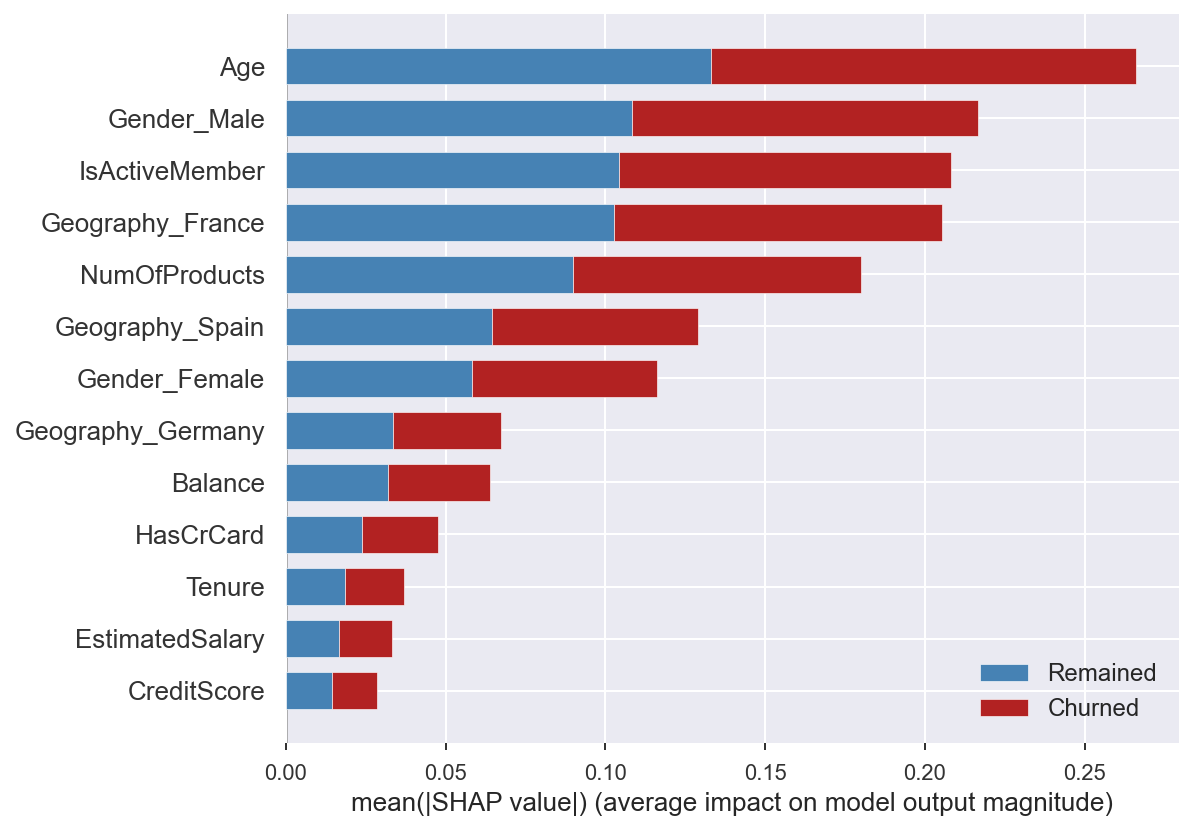

In [181]:
from matplotlib import colors as plt_colors

# class names
classes = ['Remained','Churned']

# set RGB tuple per class
colors = ['#4682b4','#b22222']

# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])


shap.summary_plot(shap_values, X_train, plot_type="bar", color=cmap, class_names=classes)

From the above summary plot, it can be inferred that age,gender_male, IsActiveMember, geography_france, and number of prodcuts are most important features and this is conformed by EDA plot.

### Summary plot for each class - Remained and Churned

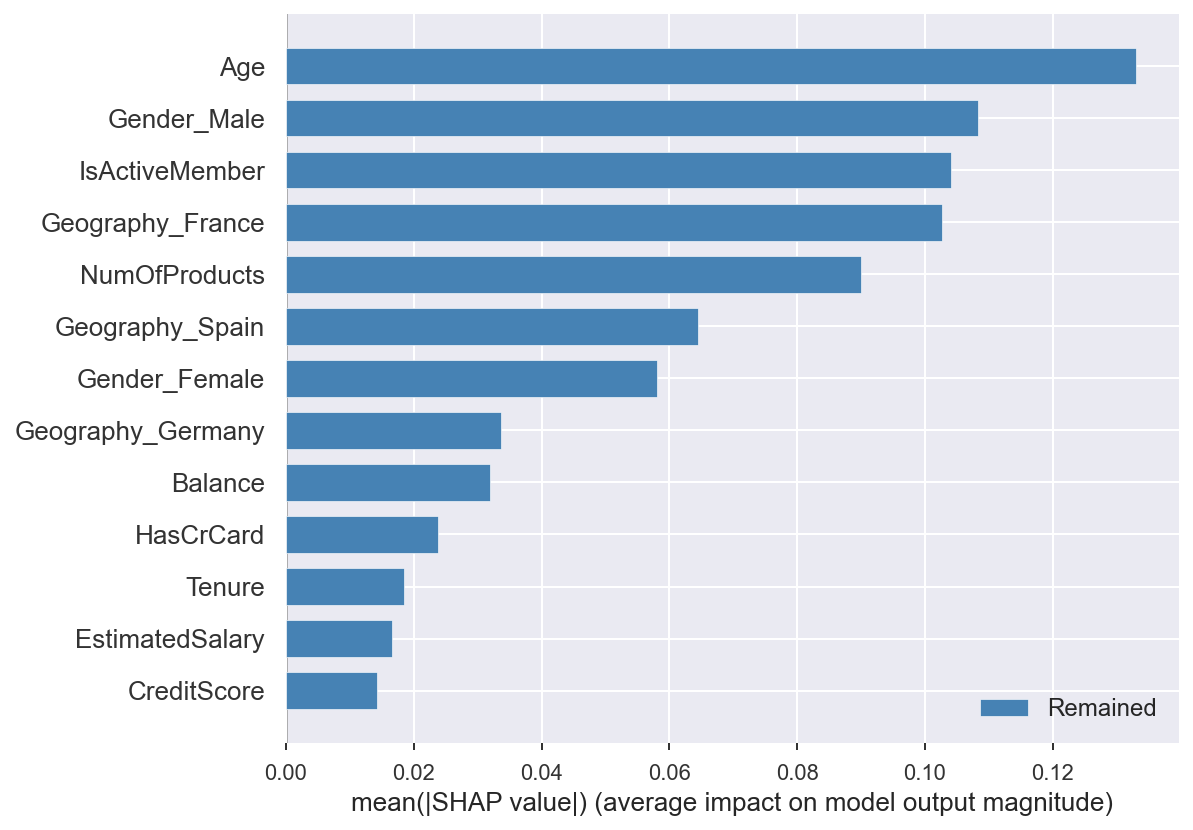

Class: Remained  0


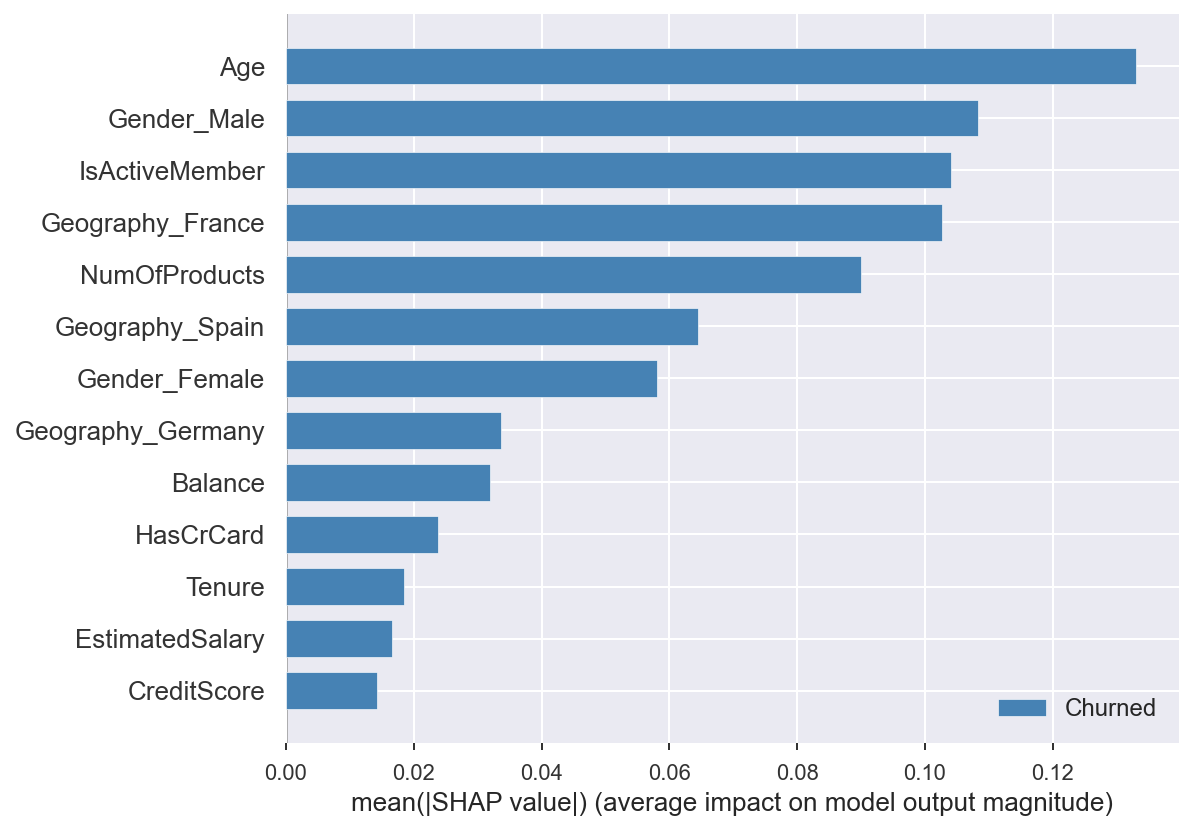

Class: Churned  1


In [182]:
# set RGB tuple per class
colors = ['#4682b4','#b22222']

# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

for i in range(len(classes)):  
    plot = shap.summary_plot(shap_values, X_test,class_names=classes,class_inds=[i],color=cmap)
    print("Class: "+classes[i] +'  ' +str(i))

Customer:Remained


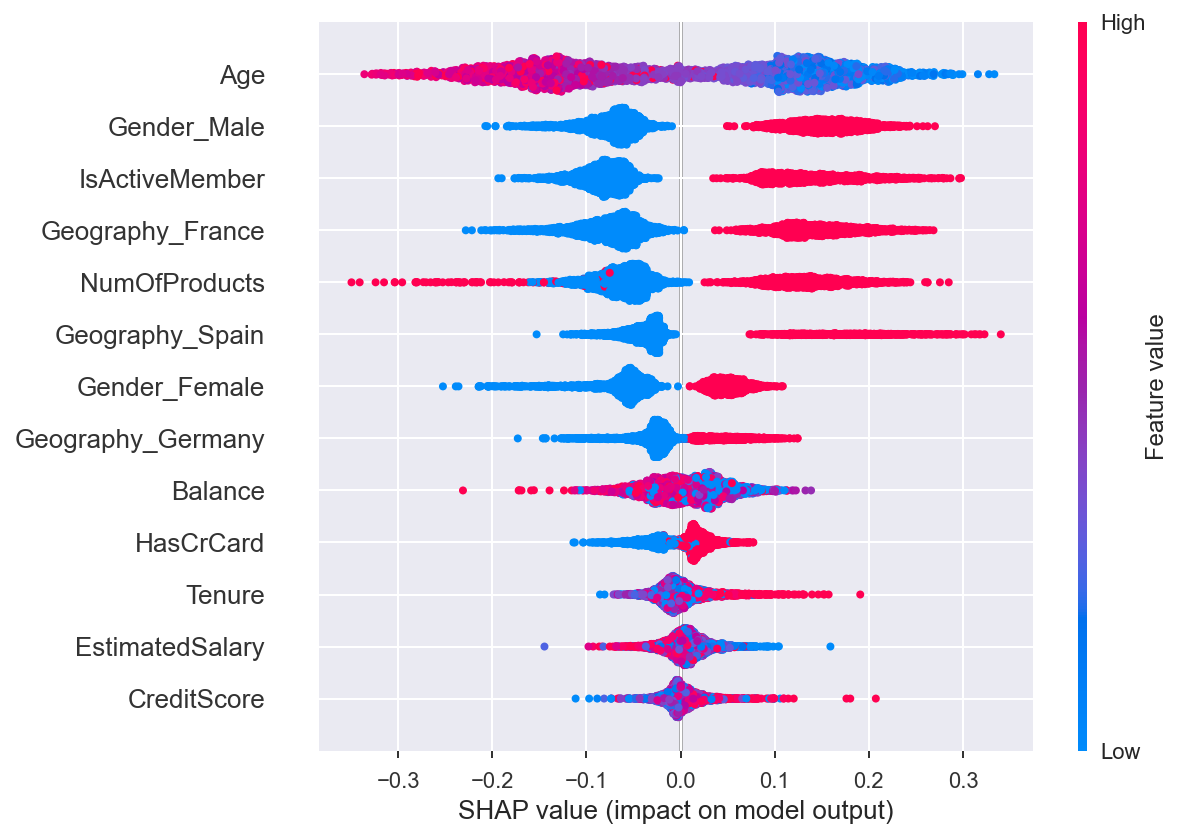

Customer:Churned


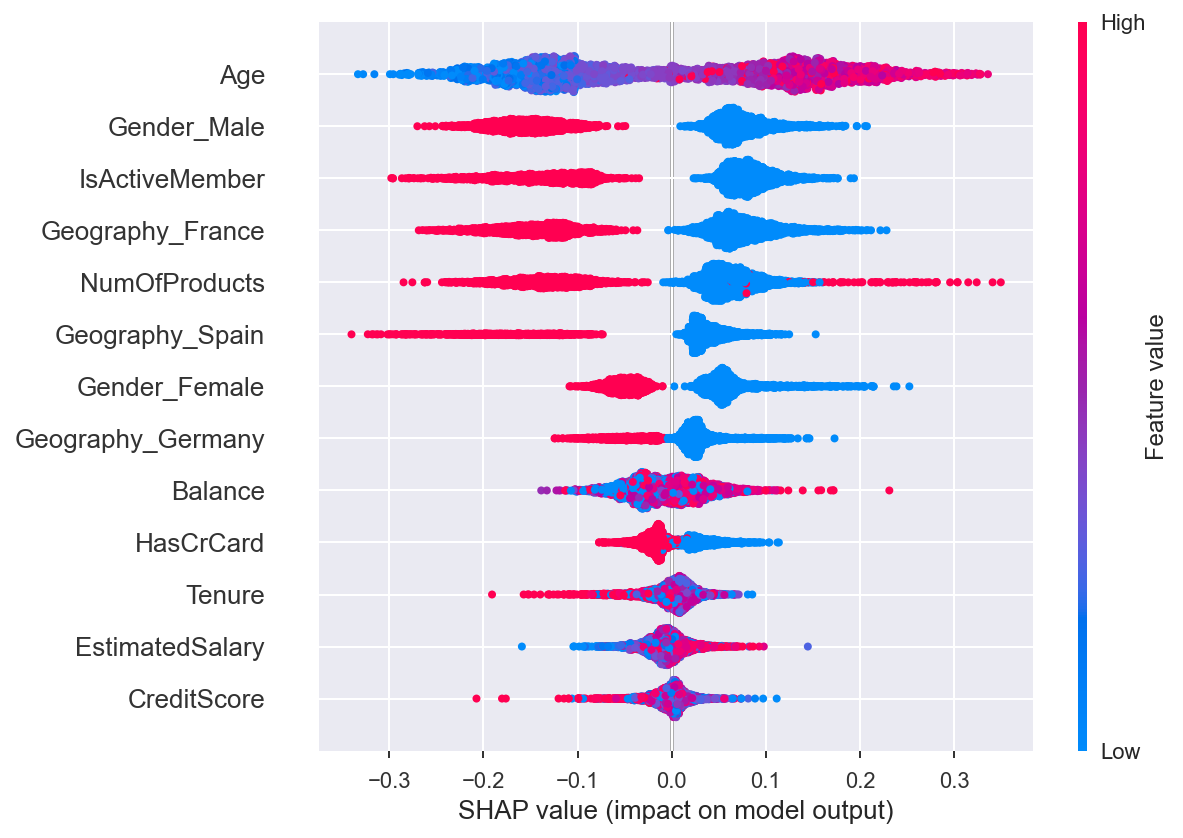

In [183]:
# class names
classes = ['Remained','Churned']

for i in range(len(classes)):  
    print("Customer:"+classes[i])
    shap.summary_plot(shap_values[i], X_test)

##### For remained customers: 

Age : Young people (indicated by blue) have predicted chance of being a customer with bank whereas older people (indicated by red) are likely to be churn customers.

Gender_Male: High feature value (indicated by red, i.e male) increases the chance of being a customer of the bank.

IsActiveMember: High feature value (indicated by red) indicates customer being active and will remain with the bank and those customers who are not active member are going to churn

Geography_France: High fetaure value (indicated by red) indicates that the customers will remain with the bank

Number of Products: if customers bought products i.e it is too high ( product number. 4, 3) then they are likely to churn whereas customers who bought product number 2 and 1 are likely to increase the chances of continuing being a customer.

Geography_Spain: High fetaure value (indicated by red) indicates that the customers will remain with the bank

Gender_Female: The feature gender_female customers is less important than gender_male feature for remained customers. But high fetaure value (indicated by red) increases the chance of being a customer of the bank.


##### For churned customers: 

Age : Older aged people (indicated by red) are likely to leave the bank.

Gender_Male: Low feature value (indicated by blue, i.e male) increases the chance of a customer leaving the bank.

IsActiveMember: Low feature value (indicated by blue) indicates customer being inactive and will churn.

Geography_France: Low fetaure value (indicated by blue) indicates that the customers will churn.

Number of Products: if customers bought products i.e it is too high ( product no. 4, 3) then they are likely to churn whereas customers who bought product no. 2 or 1 are likely to increase the chances of continuing being a customer.

Geography_Spain: Low fetaure value (indicated by blue) indicates that the customers will churn.

Gender_Female: The feature gender_female customers is less important than gender_male feature for churned customers







## Force plot : Local Interpretability

In [184]:
X_test.iloc[0,:]

Geography_Germany        0.0
IsActiveMember           0.0
Gender_Female            0.0
Age                     25.0
Geography_France         1.0
Gender_Male              1.0
Balance                  0.0
Geography_Spain          0.0
NumOfProducts            2.0
CreditScore            787.0
Tenure                   5.0
EstimatedSalary      47307.9
HasCrCard                1.0
Name: 0, dtype: float64

In [185]:
shap.initjs()
j = 0
shap_values = explainer.shap_values(X_test.iloc[j,:])
shap.force_plot(explainer.expected_value[0],shap_values[0],X_test.iloc[j,:])

#####  Observations for shap_plot(0):              

Output value: is the prediction for this observation. The prediction for this observation is 1.00.

Base value: The original paper explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 0.5009.

Features: The above explanation shows features that contributes to push the final prediction away from the base value.

Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

Gender_male: Since the customer is a male which is the most important feature, it pushes the prediction right/high.

Age: In the above force plot, the age is 25 which is lower than the average age so it drives the prediction right/high.

IsActiveMember: Since the customer is an inactive member(IsActiveMember = 0) it pushes the prediction left/low.

Geography_france: The value of Geography_france being 1 has an impact on pushing the prediction to the right as the feature ia an important.

NumberOfProducts: Since the customer has Product Number 2 which increases the prediction too the right/high.


In [186]:
j = 1
shap_values = explainer.shap_values(X_test.iloc[j,:])
shap.force_plot(explainer.expected_value[0],shap_values[0],X_test.iloc[j,:])

#####  Observations for shap_plot(1):              

Output value: is the prediction for this observation. The prediction for this observation is 1.00.

Base value: The original paper explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 0.5009.

Features: The above explanation shows features that contributes to push the final prediction away from the base value.

Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

Gender_male: Since the customer is a male which is the most important feature, it pushes the prediction right/high.

Age: In the above force plot, the age is 33 which is lower than the average age so it drives the prediction right/high.

Geography_germany: The value of Geography_france being 1 has an impact on pushing the prediction to the right as the feature is an important.

NumberOfProducts: Since the customer has Product Number 2 which increases the prediction too the right/high.

In [187]:
j = 2
shap_values = explainer.shap_values(X_test.iloc[j,:])
shap.force_plot(explainer.expected_value[0],shap_values[0],X_test.iloc[j,:])

#####  Observations for shap_plot(2):              

Output value: is the prediction for this observation. The prediction for this observation is 0.40.

Base value: The original paper explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 0.5009.

Features: The above explanation shows features that contributes to push the final prediction away from the base value.

Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

Gender_male: Since the customer is not male which is the most important feature, it pushes the prediction left/low.

Age: In the above force plot, the age is 42 which is higher than the average age so it drives the prediction left/low.

Geography_germany: The value of Geography_germany being 1 has an impact on pushing the prediction to the right as the feature is an important.

NumberOfProducts: Since the customer has Product Number 2 which increases the prediction too the right/high.

Gender_female: Since the customer is female it pushes the prediction right/high.

IsActiveMember: Since the customer is not an active member it pushes the prediction left/low.



## Force plot : Global Interpretability

Taking many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire test dataset

In [192]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], features=X_test.iloc[:100, :])

## Dependence plot

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


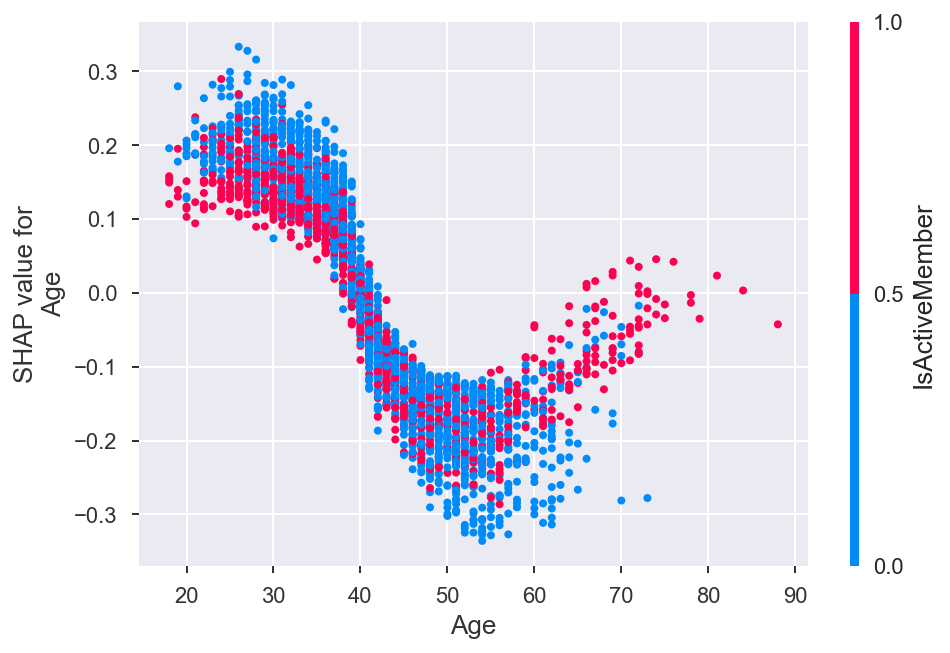

In [193]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Age", shap_values[0], X_test)

###### Observations: 

The target variable exited highly depends on age. 

The feature age has high interaction with the feature IsActiveMember.

IsActiveMember = 1 implies people are active(yes)
IsActiveMember = 0 implies people are inactive(no)

It can be observed that there are very less active members after the age of 70.
After the age of 60, it looks like customer who are active member stay with the bank.

Shap values are high until the age of 40, and then slowly decreases after that which implies that cutomers are likely to churn after the age of 40.



## Conclusion

From the above summary plot, it can be inferred that age,gender_male, IsActiveMember, geography_france, and number of prodcuts are most important features and this is conformed by EDA plot.

From force plot: global interpreability explanations for an entire test dataset can be observed.

From the dependence plot, it can be observed that age interacts highly with IsActiveMember.

## Decision plot

In [1]:
#Decision plot for individual record
j=0
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[[j]])

NameError: name 'shap' is not defined

## Interaction plot

In [ ]:
shap.TreeExplainer(model).shap_interaction_values(X_train)

In [145]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test.iloc[:2000,:])

TypeError: only size-1 arrays can be converted to Python scalars

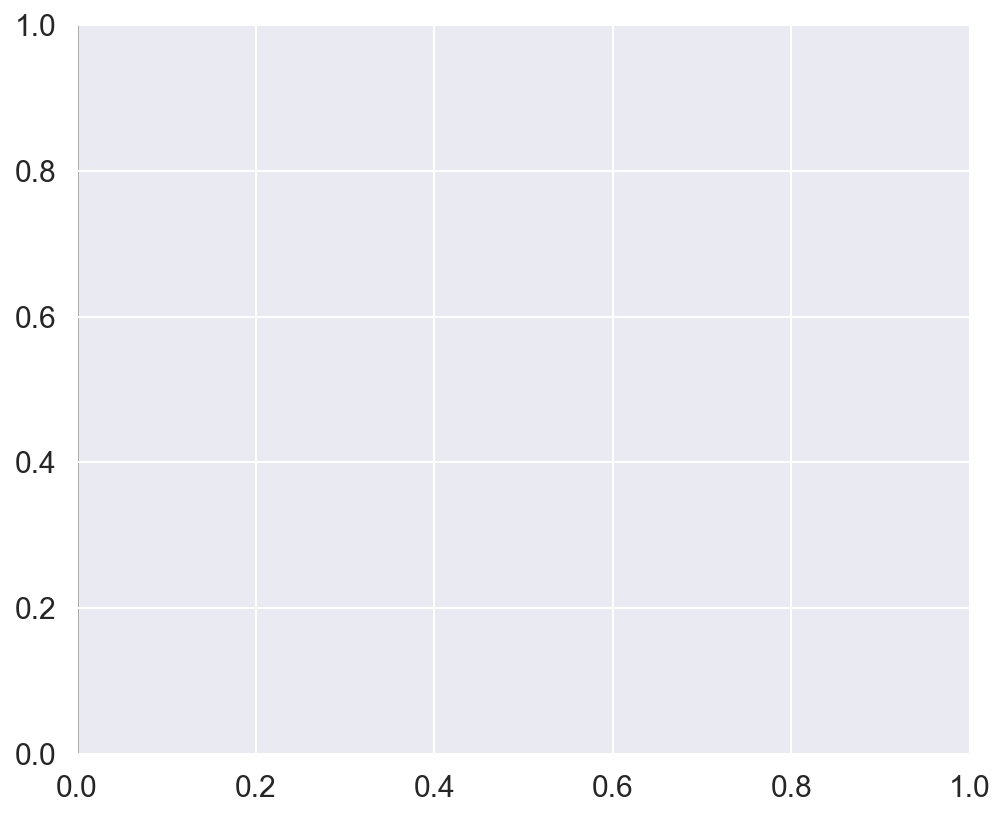

In [146]:
shap.summary_plot(shap_interaction_values, X_test.iloc[:2000,:])

The steps followed to achieve the goal are:

1. Read data from CSV file and checked for any missing values using info() of pandas library 
2. Performed Exploratory Data Analysis (EDA) to understand the data using pandas profiling report and dropped unneccesary columns
3. Analyzed the independent variables visually using histogram and box plots
4. Implemented data preprocessing by using one-hot encoding to encode the catogoreical variables
5. Performed data normalization in order normaliza the data
6. Splitting the data into train and test dataset by using 75% of the training data for actual training purposes, and once training is completed, using the remaining 25% of the training data to check the training accuracy of the trained model.
7. Since the data set is imbalanced, increasing the number of samples using SMOTE.
8. Training and predicting the output using Random Forest algorithm. The accuracy of the model is 78%.
9. Interpretation using SHAP - TreeExplainer is a package for explaining and interpreting predictions of tree-based machine learning models. The notion of interpretability is based on how close the inclusion of a feature takes the model toward its final prediction. For this reason, the result of this approach is "feature contributions" to the predictions.
10.

# Problem with this notebook 

1. Error for plotting force plot 

2. Since its RF, normalization is not required, although I normalize getting this error ( explain)